# 1. Imports

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

import random
import os

# 2. Data Loading and Preprocessing

### 2.1 Data Loading Function (audio file -> tensor)

In [ ]:
def load_wav_default_mono(filename):
    new_sr = 22050
    
    file_contents = tf.io.read_file(filename)
    
    y, sr = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    y = tf.squeeze(y, axis=-1)
    sr = tf.cast(sr, dtype=tf.int64)
    
    y = tfio.audio.resample(y, rate_in=sr, rate_out=new_sr)
    
    return y

### 2.2 Preprocessing Function (tensor -> default length tensor -> mel spectrogram 

In [ ]:
def preprocess(filename, label):
    y = load_wav_default_mono(filename)
    
    max_len = 66150 # 3s audio for 22050hz
    
    y = y[:max_len]
    try:
        start_padding = tf.zeros(random.randint(0, max_len - len(y)), dtype=tf.float32)
        end_padding = tf.zeros(max_len - len(y) - len(start_padding), dtype=tf.float32)
    except:
        start_padding = tf.zeros(max_len - len(y), dtype=tf.float32)
        end_padding = tf.zeros(max_len - len(y) - len(start_padding), dtype=tf.float32)
        
    y = tf.concat([start_padding, y, end_padding], axis=0)
    
    spectrogram = tfio.audio.spectrogram(y, nfft=512, window=128, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=22050, mels=128, fmin=0, fmax=8000)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    expanded_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)

    
    return expanded_spectrogram, label

### 2.3 Testing preprocess

In [ ]:
spectrogram, label = preprocess(os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav'), 1)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
#plt.show()

# 3. Creating the Tensorflow Pipeline 

### 3.1 Saving the folders paths

In [40]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

### 3.2 Adding all the filenames to tf Dataset objects

In [41]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

### 3.3 "Zipping" with the respective labels and concatenating both to a "data" varaiable

In [42]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

### 3.3 Building the pipeline on the data Dataset

In [43]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

### 3.4 Partitioning into train and test datasets

In [44]:
len(data)*.7

35.699999999999996

In [45]:
train = data.take(36)
test = data.skip(36).take(15)

### 3.5 Viewing the shape of the input for the model

In [46]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 259, 128, 1)

# 4. Building the Deep Learning Model

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout

### 4.1 Adding layers

In [64]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(259, 128, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### 4.2 Compile and viewing the model

In [65]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [66]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 257, 126, 16)      160       
                                                                 
 conv2d_13 (Conv2D)          (None, 255, 124, 16)      2320      
                                                                 
 flatten_5 (Flatten)         (None, 505920)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               64757888  
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                

### 4.3 Training and Saving

In [67]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 13s 344ms/step - loss: 26.3772 - recall_3: 0.6364 - precision_3: 0.5765 - val_loss: 0.2620 - val_recall_3: 0.9492 - val_precision_3: 0.8889
Epoch 2/4
36/36 [==============================] - 12s 340ms/step - loss: 0.3799 - recall_3: 0.8385 - precision_3: 0.9000 - val_loss: 0.0652 - val_recall_3: 0.8971 - val_precision_3: 1.0000
Epoch 3/4
36/36 [==============================] - 12s 337ms/step - loss: 0.2617 - recall_3: 0.8784 - precision_3: 0.9155 - val_loss: 0.0157 - val_recall_3: 0.9863 - val_precision_3: 0.9863
Epoch 4/4
36/36 [==============================] - 12s 338ms/step - loss: 0.0699 - recall_3: 0.9484 - precision_3: 0.9671 - val_loss: 0.0331 - val_recall_3: 0.9831 - val_precision_3: 0.9831


In [ ]:
# model.save('model_practise')

# with open('/trainHistoryDict', 'wb') as file_pi:
#         pickle.dump(hist.history, file_pi)

In [77]:
print(hist.history.keys())

dict_keys(['loss', 'recall_3', 'precision_3', 'val_loss', 'val_recall_3', 'val_precision_3'])


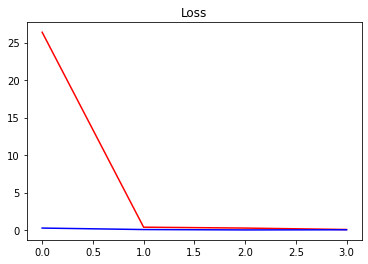

In [70]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

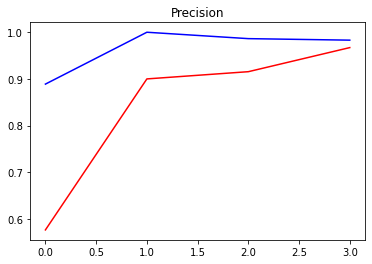

In [79]:
plt.title('Precision')
plt.plot(hist.history['precision_3'], 'r')
plt.plot(hist.history['val_precision_3'], 'b')
plt.show()

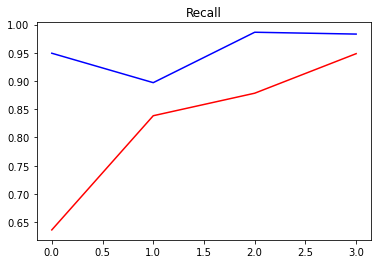

In [78]:
plt.title('Recall')
plt.plot(hist.history['recall_3'], 'r')
plt.plot(hist.history['val_recall_3'], 'b')
plt.show()

# 5. Predictions for testing

### 5.1 Getting a batch from the test dataset

In [90]:
x_test, y_test = test.as_numpy_iterator().next()

### 5.2 Making predictions on the batch

In [91]:
yhat = model.predict(x_test)

1/1 [==============================] - 0s 48ms/step


In [92]:
yhat

array([[6.5128607e-16],
       [9.4111182e-19],
       [1.0000000e+00],
       [1.0753854e-02],
       [9.9999976e-01],
       [1.0000000e+00],
       [2.5122135e-10],
       [9.9760276e-01],
       [1.3052126e-04],
       [1.0000000e+00],
       [1.1365690e-03],
       [4.0485177e-13],
       [7.1047907e-08],
       [1.0000000e+00],
       [7.4969462e-06],
       [2.7361806e-19]], dtype=float32)

In [93]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [94]:
for i in range(len(yhat)):
    print('Data: '+ str(y_test[i].astype(int)) + ' / Prediction: ' + str(yhat[i])) 

Data: 0 / Prediction: 0
Data: 0 / Prediction: 0
Data: 1 / Prediction: 1
Data: 0 / Prediction: 0
Data: 1 / Prediction: 1
Data: 1 / Prediction: 1
Data: 0 / Prediction: 0
Data: 1 / Prediction: 1
Data: 0 / Prediction: 0
Data: 1 / Prediction: 1
Data: 0 / Prediction: 0
Data: 0 / Prediction: 0
Data: 0 / Prediction: 0
Data: 1 / Prediction: 1
Data: 0 / Prediction: 0
Data: 0 / Prediction: 0


In [86]:
y_test.astype(int)

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0])

# 6. Working on the Forest Data

### 6.1 Adapting the functions for mp3 files

In [123]:
def load_mp3_default_mono(filename):
    new_sr = 22050
    
    file_contents = tfio.audio.AudioIOTensor(filename)
    
    y = file_contents.to_tensor()
    y = tf.math.reduce_sum(y, axis=1) / 2
    
    sr = file_contents.rate
    sr = tf.cast(sr, dtype=tf.int64)
    
    y = tfio.audio.resample(y, rate_in=sr, rate_out=new_sr)
    
    return y

def preprocess_mp3(sample, index):
    y = sample[0]
    
    max_len = 66150 # 3s audio for 22050hz
    
    y = y[:max_len]
    try:
        start_padding = tf.zeros(random.randint(0, max_len - len(y)), dtype=tf.float32)
        end_padding = tf.zeros(max_len - len(y) - len(start_padding), dtype=tf.float32)
    except:
        start_padding = tf.zeros(max_len - len(y), dtype=tf.float32)
        end_padding = tf.zeros(max_len - len(y) - len(start_padding), dtype=tf.float32)
        
    y = tf.concat([start_padding, y, end_padding], axis=0)
    
    spectrogram = tfio.audio.spectrogram(y, nfft=512, window=128, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=22050, mels=128, fmin=0, fmax=8000)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    expanded_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)

    
    return expanded_spectrogram

### 6.2 Converting a large audio file into Windows and making predictions

In [97]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [100]:
y = load_mp3_default_mono(mp3)

In [119]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(y, y, sequence_length=66150,
                                                     sequence_stride=66150, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [141]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 0s 239ms/step


In [142]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

### 6.3 Grouping Consecutive Detections

In [143]:
from itertools import groupby

In [144]:
yhat = [key for key, group in groupby(yhat)]

In [145]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [146]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

# 7. Predictions on Forest Recordings

### 7.1 Big Function for everything

In [218]:
def predict(filename, predictions):
    y = load_mp3_default_mono(filename)
    
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(y, y, sequence_length=66150,
                                                     sequence_stride=66150, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    predictions = model.predict(audio_slices)
    predictions = [1 if prediction > 0.99 else 0 for prediction in predictions]
    
    predictions = [key for key, group in groupby(predictions)]
    predictions = int(tf.math.reduce_sum(predictions))
    
    return filename, predictions

In [219]:
predictions = 0

mp2, predictions = predict(mp3, predictions)
print(predictions)

1/1 [==============================] - 0s 273ms/step
5


### 7.2 Makings the Predictions

In [164]:
# RES = os.path.join('data', 'Forest Recordings')
# res = tf.data.Dataset.list_files(RES + '/*.mp3')
# results = tf.data.Dataset.zip((res, tf.data.Dataset.from_tensor_slices(tf.zeros(len(res)))))

# results = results.map(predict)

In [212]:
results = {}
i=0
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    filename = os.path.join('data', 'Forest Recordings', file)
    
    filename, predictions = predict(filename, predictions)
    
    results[file] = predictions

1/1 [==============================] - 0s 273ms/step


In [213]:
results

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 4,
 'recording_17.mp3': 3,
 'recording_18.mp3': 1,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 0,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 4,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 2,
 'recording_40.mp3': 1,
 'recording_41.

# 8. Exporting Results

In [214]:
import csv

In [216]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in results.items():
        writer.writerow([key, value])